In [98]:
import requests
import json
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import xgboost
from xgboost.sklearn import XGBClassifier, XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./data/최종_최종__월별기상관측.csv', encoding='cp949')
df = df.drop(['Unnamed: 0'], axis=1)

In [3]:
region = df['행정구역'].unique()
region

array(['강원도', '경기도', '인천광역시', '서울특별시', '경상북도', '충청북도', '충청남도', '대전광역시',
       '전라남도', '대구광역시', '전라북도', '울산광역시', '경상남도', '광주광역시', '부산광역시', '제주도',
       '세종특별자치시'], dtype=object)

In [4]:
# g = df[(df['행정구역'] == '강원도')]

In [5]:
# g

In [6]:
# t_date = g['일시'].unique()

In [7]:
# t_date

In [8]:
#t = g[(g['일시'] == '2000-01')]

In [9]:
#t

In [10]:
#t.describe()['평균기온(°C)']

In [11]:
#t.describe()['평균기온(°C)']['50%']

In [12]:
def calc_median(df:pd.DataFrame, colname:str):
    # df(데이터 프레임) colname의 중앙값 산출하는 함수
    return df.describe()[colname]['50%']

In [13]:
reg_df = pd.DataFrame()

for reg in region:
    print(f'행정구역 : {reg}')
    temp_mean_list, temp_max_list, temp_min_list, rain_sum_list, sun_sum_list = [],[],[],[],[] # 중앙값 데이터 쌓을 빈 리스트 생성 (초기화)
    
    d = df[(df['행정구역'] == reg)] # 행정구역의 df 생성.
    date_list = d['일시'].unique() # 일시 리스트 생성.
    
    for date in date_list:
        r = d[(d['일시'] == date)] # 예 : 행정구역이 강원도 이면서 일시가 2000-01 인 데이터 프레임
        
        # 컬럼별 중앙값 구하기.
        temp_mean = calc_median(r, '평균기온(°C)')
        temp_max = calc_median(r, '최고기온(°C)')
        temp_min = calc_median(r, '최저기온(°C)')
        rain_sum = calc_median(r, '월합강수량(00~24h만)(mm)')
        sun_sum = calc_median(r, '합계 일사량(MJ/m2)')
        
        # 구한 중앙값들을 각 리스트에 쌓기.
        temp_mean_list.append(temp_mean)
        temp_max_list.append(temp_max)
        temp_min_list.append(temp_min)
        rain_sum_list.append(rain_sum)
        sun_sum_list.append(sun_sum)
    # 임의의 데이터 프레임으로 만들기. 
    imsi_df = pd.DataFrame({'행정구역':reg, '일시':date_list,'평균기온(°C)': temp_mean_list,
                           '최고기온(°C)': temp_max_list, '최저기온(°C)': temp_min_list,
                           '월합강수량(00~24h만)(mm)':rain_sum_list,'합계 일사량(MJ/m2)':sun_sum_list})
    # 위에서 생성한 빈 reg_df와 임의의 데이터 프레임 합치기
    reg_df = pd.concat([reg_df, imsi_df], axis=0)
reg_df.reset_index(inplace=True, drop=True)
        

행정구역 : 강원도
행정구역 : 경기도
행정구역 : 인천광역시
행정구역 : 서울특별시
행정구역 : 경상북도
행정구역 : 충청북도
행정구역 : 충청남도
행정구역 : 대전광역시
행정구역 : 전라남도
행정구역 : 대구광역시
행정구역 : 전라북도
행정구역 : 울산광역시
행정구역 : 경상남도
행정구역 : 광주광역시
행정구역 : 부산광역시
행정구역 : 제주도
행정구역 : 세종특별자치시


In [14]:
df = reg_df

In [15]:
# 봄배추 3월~5월
# 고랭지배추 5월~9월
# 가을배추 7월~11월
# 겨울배추 8월~내년2월
#평균기온, 최저기온, 최고기온, 월합강수량, 합계일사량 

In [16]:
# 일시 뽑을 방법 확인
df['일시'][0][-2:]

'01'

In [17]:
# 월만 추가
# month = df['일시'].apply(lambda x:x.split('-')[-1])
# df.insert(3, '월', month)
df['월'] = df['일시'].apply(lambda x:x.split('-')[-1])
df.head()

,행정구역,일시,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2),월
0,강원도,2000-01,-2.9,8.5,-16.0,48.1,152.990,01
1,강원도,2000-02,-3.3,7.7,-15.8,5.7,329.070,02
2,강원도,2000-03,4.4,19.3,-8.6,14.1,448.650,03
3,강원도,2000-04,10.4,23.7,-3.1,37.1,486.355,04
4,강원도,2000-05,15.9,31.6,3.9,75.2,520.280,05


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4488 entries, 0 to 4487
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   행정구역                4488 non-null   object 
 1   일시                  4488 non-null   object 
 2   평균기온(°C)            4488 non-null   float64
 3   최고기온(°C)            4488 non-null   float64
 4   최저기온(°C)            4488 non-null   float64
 5   월합강수량(00~24h만)(mm)  4488 non-null   float64
 6   합계 일사량(MJ/m2)       4488 non-null   float64
 7   월                   4488 non-null   object 
dtypes: float64(5), object(3)
memory usage: 280.6+ KB


In [19]:
#겨울배추 추가
winter_df = df.loc[(df['월'] == '01')|(df['월'] == '02')|(df['월'] == '08')|(df['월'] == '09')|(df['월'] == '10')|(df['월'] == '11')|(df['월'] == '12')]

In [20]:
#봄배추, 고랭지배추, 가을배추 추가
spring_df =  df.loc[(df['월'] == '03')|(df['월'] == '04')|(df['월'] == '05')]
gorange_df = df.loc[(df['월'] == '05')|(df['월'] == '06')|(df['월'] == '07')|(df['월'] == '08')|(df['월'] == '9')]
fall_df = df.loc[(df['월'] == '07')|(df['월'] == '08')|(df['월'] == '09')|(df['월'] == '10')|(df['월'] == '11')]

In [21]:
spring_df

,행정구역,일시,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2),월
2,강원도,2000-03,4.4,19.3,-8.6,14.1,448.650,03
3,강원도,2000-04,10.4,23.7,-3.1,37.1,486.355,04
4,강원도,2000-05,15.9,31.6,3.9,75.2,520.280,05
14,강원도,2001-03,3.3,21.6,-8.5,20.6,445.030,03
15,강원도,2001-04,12.0,27.3,-4.1,16.5,539.605,04
...,...,...,...,...,...,...,...,...
4467,세종특별자치시,2020-04,10.8,25.9,-0.8,17.6,651.275,04
4468,세종특별자치시,2020-05,18.2,29.1,7.5,91.6,643.645,05
4478,세종특별자치시,2021-03,8.8,23.3,-2.3,99.8,465.040,03
4479,세종특별자치시,2021-04,13.9,29.8,0.7,56.0,585.900,04


In [22]:
spring_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122 entries, 2 to 4480
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   행정구역                1122 non-null   object 
 1   일시                  1122 non-null   object 
 2   평균기온(°C)            1122 non-null   float64
 3   최고기온(°C)            1122 non-null   float64
 4   최저기온(°C)            1122 non-null   float64
 5   월합강수량(00~24h만)(mm)  1122 non-null   float64
 6   합계 일사량(MJ/m2)       1122 non-null   float64
 7   월                   1122 non-null   object 
dtypes: float64(5), object(3)
memory usage: 78.9+ KB


In [23]:
# 배추품종에 따라 값을 부여함

winter_df['배추품종'] = '겨울배추'
spring_df['배추품종'] = '봄배추'
gorange_df['배추품종'] = '고랭지배추'
fall_df['배추품종'] = '겨울배추'

In [24]:
spring_df

,행정구역,일시,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2),월,배추품종
2,강원도,2000-03,4.4,19.3,-8.6,14.1,448.650,03,봄배추
3,강원도,2000-04,10.4,23.7,-3.1,37.1,486.355,04,봄배추
4,강원도,2000-05,15.9,31.6,3.9,75.2,520.280,05,봄배추
14,강원도,2001-03,3.3,21.6,-8.5,20.6,445.030,03,봄배추
15,강원도,2001-04,12.0,27.3,-4.1,16.5,539.605,04,봄배추
...,...,...,...,...,...,...,...,...,...
4467,세종특별자치시,2020-04,10.8,25.9,-0.8,17.6,651.275,04,봄배추
4468,세종특별자치시,2020-05,18.2,29.1,7.5,91.6,643.645,05,봄배추
4478,세종특별자치시,2021-03,8.8,23.3,-2.3,99.8,465.040,03,봄배추
4479,세종특별자치시,2021-04,13.9,29.8,0.7,56.0,585.900,04,봄배추


In [25]:
# 생산량 데이터 불러와서 . . . 전처리 . . 
# pandas wide to long 검색해서 배추 생산량 데이터 ,, 데이터 프레임 형태로 만들기
# 16일은 데이터 프레임 형태 이후 합치고 전처리

In [26]:
# import pandas as pd
#데이터 프레임 만들기


In [27]:
# 생산량 데이터
# produce_df = pd.read_csv('./배추_생산량.csv')

# 배추별 특징(겨울배추는 2014년 부터 있음)
# 노지봄배추 = 노지봄배추 + 일반봄배추
# 노지배추 = 일반봄배추 + 고랭지배추 + 노지가을배추 + 노지겨울배추
# 배추 = 노지봄배추 + 일반봄배추  + 고랭지배추 + 노지가을배추 + 노지겨울배추 + 시설배추

In [28]:
# region2 = produce_df.iloc[1:, :1]

# year = [y.split('.')[0] for y in produce_df.iloc[:, 1:].columns] #년도에서 .을 기준으로 뒤에 제거 후 저장(년도만)
# handle_df = produce_df.iloc[:, 1:] #시도별 열을 제외한 데이터 

In [29]:
#a = [y.split('.')[0] for y in produce_df.iloc[:, 1:].columns]
#a

In [30]:
# produce_df.iloc[:, 1:] 

In [31]:
# handle_df.insert(0, '행정구역', region2['시도별'].tolist())

In [32]:
# produce_df2 = pd.melt(handle_df, id_vars=['행정구역'])
# produce_df2

In [33]:
# produce_df.iloc[:, 1:]

In [34]:
# produce_df.iloc[1:, :1]

In [35]:
# df_2000 = produce_df.iloc[1:, :23]
# df_2001 = produce_df.iloc[1:, 23:45]
# df_2002 = produce_df.iloc[1:, 45:67]
# df_2003 = produce_df.iloc[1:, 67:89]
# df_2004 = produce_df.iloc[1:, 89:111]
# df_2005 = produce_df.iloc[1:, 111:133]
# df_2006 = produce_df.iloc[1:, 133:155]
# df_2007 = produce_df.iloc[1:, 155:177]
# df_2008 = produce_df.iloc[1:, 177:199]
# df_2009 = produce_df.iloc[1:, 199:221]
# df_2010 = produce_df.iloc[1:, 221:243]
# df_2011 = produce_df.iloc[1:, 243:265]
# df_2012 = produce_df.iloc[1:, 265:287]
# df_2013 = produce_df.iloc[1:, 287:309]
# df_2014 = produce_df.iloc[1:, 309:334]
# df_2015 = produce_df.iloc[1:, 334:359]
# df_2016 = produce_df.iloc[1:, 359:384]
# df_2017 = produce_df.iloc[1:, 384:409]
# df_2018 = produce_df.iloc[1:, 409:434]
# df_2019 = produce_df.iloc[1:, 434:459]
# df_2020 = produce_df.iloc[1:, 459:484]
# df_2021 = produce_df.iloc[1:, 484:509]

In [36]:
# df_2000 = produce_df.iloc[1:, 1:23]
# df_2000


In [37]:
# df_2000 = produce_df.iloc[1:, 1:23]
# df_2000.columns = ['엽채류:면적 (ha)', '생산량 (톤)','배추:면적 (ha)', '생산량 (톤)', '노지배추:면적 (ha)',
#        '10a당 생산량 (kg)', '생산량 (톤)', '노지봄배추:면적 (ha)', '일반봄배추:면적 (ha)', '고랭지배추:면적 (ha)',
#        '노지가을배추:면적 (ha)', '시설배추:면적 (ha)', '노지겨울배추:면적 (ha)']

In [38]:
# new_data = pd.concat([df_2000, df_2001], axis=0)

In [39]:
# new_data

생산량 데이터 전처리

In [40]:
# 다시불러오기
df2 = pd.read_csv('./data/배추_생산량.csv')

In [41]:
df2.head()

,시도별,2000,2000.1,2000.2,2000.3,2000.4,2000.5,2000.6,2000.7,2000.8,...,2021.2,2021.3,2021.4,2021.5,2021.6,2021.7,2021.8,2021.9,2021.10,2021.11
0,품목별,일반봄배추:면적 (ha),10a당 생산량 (kg),생산량 (톤),고랭지배추:면적 (ha),10a당 생산량 (kg),생산량 (톤),노지가을배추:면적 (ha),10a당 생산량 (kg),생산량 (톤),...,생산량 (톤),고랭지배추:면적 (ha),10a당 생산량 (kg),생산량 (톤),노지가을배추:면적 (ha),10a당 생산량 (kg),생산량 (톤),노지겨울배추:면적 (ha),10a당 생산량 (kg),생산량 (톤)
1,서울특별시,72,3695,2660,0,0,0,23,10152,2335,...,228,0,0,0,6,12793,771,0,0,0
2,부산광역시,403,4446,17917,0,0,0,324,10835,35105,...,259,0,0,0,36,11239,4017,0,0,0
3,대구광역시,177,4799,8494,0,0,0,139,10657,14813,...,1343,0,0,0,68,7248,4895,0,0,0
4,인천광역시,107,4316,4618,0,0,0,166,9907,16446,...,378,0,0,0,138,9664,13333,0,0,0


In [42]:
def new_columns(collist):
    new_colnames = []
    for i in range(len(collist[:])):
        if ':' in collist[:][i]:
            new_colnames.append(collist[:][i])
        else:
            if ':' in collist[:][i-1]:
#                 print(collist[:][i-1])
                new_colname = collist[:][i-1].split(':')[0] + ':' + collist[:][i]
                new_colnames.append(new_colname)
            elif ':' in collist[:][i-2]:
                new_colname = collist[:][i-2].split(':')[0] + ':' + collist[:][i]
                new_colnames.append(new_colname)
    return new_colnames

In [43]:
region2 = df2.iloc[1:, :1]['시도별'].tolist() #행정구역 명 
output_df = pd.DataFrame()
for y in range(2000, 2022):
    y_list = []
    for col in df2.columns:
        if col.split('.')[0] == str(y):
#             print(col.split('.')[0])
            y_list.append(col)
    print(f'{y} : {len(y_list)}')
    handle_df = df2[y_list]
    
    handle_df.columns = [handle_df[col][0] for col in handle_df.columns]
    handle_df.columns = new_columns(handle_df.columns) #칼럼명 매칭
    
    
    handle_df = handle_df.iloc[1:]
    handle_df.insert(0, '행정구역', region2)
    e_df2 = pd.melt(handle_df, id_vars=['행정구역']) #행정구역을 기준으로 wide 데이터 long 변환
    e_df2.insert(0, '일시', str(y)) #일시 추가
    output_df = pd.concat([output_df, e_df2], axis=0)
output_df.reset_index(inplace=True, drop=True)

2000 : 9
2001 : 9
2002 : 9
2003 : 9
2004 : 9
2005 : 9
2006 : 9
2007 : 9
2008 : 9
2009 : 9
2010 : 9
2011 : 9
2012 : 9
2013 : 9
2014 : 12
2015 : 12
2016 : 12
2017 : 12
2018 : 12
2019 : 12
2020 : 12
2021 : 12


In [44]:
tgt = ['일반봄배추', '고랭지배추', '노지가을배추', '노지겨울배추']
tgt_index = []
for i in range(len(output_df)):
    if output_df['variable'][i].split(':')[0] in tgt:
        print(output_df['variable'][i])
        tgt_index.append(i)

일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:면적 (ha)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:10a당 생산량 (kg)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
일반봄배추:생산량 (톤)
고랭지배추:면적 (ha)
고랭지배추:면적 (ha)
고랭지배추:면적 (ha)
고랭지배추:면적 (ha)
고랭지배추:면적 (ha)
고랭지배추:면적 (ha)
고랭지배추:면적 (ha)
고랭지배추:면적 (ha)
고랭지배추:면적 (ha)
고랭지배추:면적 (ha)
고랭지배추:면적 (ha)
고랭지배추:면적 (ha)
고랭지배추:면적 (ha)
고랭

In [45]:
print(len(tgt_index))

3774


In [46]:
output_df = output_df.loc[tgt_index]
output_df.reset_index(inplace=True, drop=True)

In [47]:
split_spcies = [v.split(':')[0] for v in output_df['variable']]
output_df.insert(3, '품종', split_spcies)
output_df['variable'] = [v.split(':')[-1] for v in output_df['variable']]  # :기준으로 분리

In [48]:
# 품종에 따른, 생산량 , 면적, 10a당 생산량 
# 면적 (ha) 생산량 (톤) 10a당 생산량 (kg)
def species_df(df, species):
    spec_df = df.loc[(df['품종'] == species)]
    spec_df.reset_index(inplace=True, drop=True)
    
    idx_l = [i for i in range(len(spec_df)) if spec_df['variable'][i] == '면적 (ha)']
    area_list = [spec_df['value'][i] for i in range(len(spec_df)) if spec_df['variable'][i] == '면적 (ha)']
    out_list = [spec_df['value'][i] for i in range(len(spec_df)) if spec_df['variable'][i] == '생산량 (톤)']
    out_10a_list = [spec_df['value'][i] for i in range(len(spec_df)) if spec_df['variable'][i] == '10a당 생산량 (kg)']
    
    result_df = spec_df.loc[idx_l]
    result_df = result_df[['일시', '행정구역', '품종']]
    
    result_df['면적'] = area_list
    result_df['생산량'] = out_list
    result_df['10a당_생산량'] = out_10a_list 
    
    result_df.reset_index(inplace=True, drop=True)
    return result_df

In [49]:
output_spring_df = species_df(output_df, '일반봄배추')
output_winter_df = species_df(output_df, '노지겨울배추')
output_grange_df = species_df(output_df, '고랭지배추')
output_fall_df = species_df(output_df, '노지가을배추')

In [50]:
# 품종 이름 변경
output_spring_df['품종'] = '봄배추'
output_winter_df['품종'] = '겨울배추'
output_grange_df['품종'] = '고랭지배추'
output_fall_df['품종'] = '가을배추'

In [51]:
output_fall_df

,일시,행정구역,품종,면적,생산량,10a당_생산량
0,2000,서울특별시,가을배추,23,2335,10152
1,2000,부산광역시,가을배추,324,35105,10835
2,2000,대구광역시,가을배추,139,14813,10657
3,2000,인천광역시,가을배추,166,16446,9907
4,2000,광주광역시,가을배추,195,20352,10437
...,...,...,...,...,...,...
369,2021,전라북도,가을배추,1296,120590,9304
370,2021,전라남도,가을배추,3226,320451,9933
371,2021,경상북도,가을배추,1712,124232,7256
372,2021,경상남도,가을배추,477,43845,9190


In [52]:
# 10a당_생산량 컬럼 삭제
output_spring_df  = output_spring_df.drop(['10a당_생산량'], axis=1)

In [53]:
output_winter_df  = output_winter_df.drop(['10a당_생산량'], axis=1)
output_grange_df  = output_grange_df.drop(['10a당_생산량'], axis=1)
output_fall_df  = output_fall_df.drop(['10a당_생산량'], axis=1)

In [54]:
output_spring_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   일시      374 non-null    object
 1   행정구역    374 non-null    object
 2   품종      374 non-null    object
 3   면적      374 non-null    object
 4   생산량     374 non-null    object
dtypes: object(5)
memory usage: 14.7+ KB


In [55]:
# output_spring_df 면적 컬럼에 - 값 확인
# output_grange_df.loc[output_grange_df['면적'] == '-']

In [56]:
# output_spring_df 생산량 컬럼에 - 값 확인
def string_to_int(t):
    if t != '-':
        t = int(t)
        return t
    else :
        return 0

In [57]:
# 면적, 생산량 컬럼 int로 변환
def convert_column_type(df):
    convert_column = ['면적', '생산량']
    for c in convert_column:
        df[c] = df[c].apply(lambda x: string_to_int(x))
    return df

In [58]:
# 문자열인 면적, 생산량 컬럼을 int로 변환
output_spring_df = convert_column_type(output_spring_df)
output_winter_df = convert_column_type(output_winter_df)
output_grange_df = convert_column_type(output_grange_df)
output_fall_df = convert_column_type(output_fall_df)

In [59]:
# 숫자 외 데이터 확인
#output_spring_df['면적'].unique()
#output_winter_df['면적'].unique()
#output_grange_df['면적'].unique()
#output_fall_df['면적'].unique()

# 기후 데이터 연별로 합치기

In [60]:
# winter_df['배추품종'] = '겨울배추'
# spring_df['배추품종'] = '봄배추'
# gorange_df['배추품종'] = '고랭지배추'
# fall_df['배추품종'] = '가을배추'

In [61]:
winter_df

,행정구역,일시,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2),월,배추품종
0,강원도,2000-01,-2.9,8.5,-16.0,48.1,152.990,01,겨울배추
1,강원도,2000-02,-3.3,7.7,-15.8,5.7,329.070,02,겨울배추
7,강원도,2000-08,24.1,33.7,17.4,348.0,412.735,08,겨울배추
8,강원도,2000-09,18.5,31.1,8.5,256.9,347.645,09,겨울배추
9,강원도,2000-10,12.1,26.1,-1.6,16.9,311.070,10,겨울배추
...,...,...,...,...,...,...,...,...,...
4483,세종특별자치시,2021-08,25.1,34.5,18.6,232.1,445.145,08,겨울배추
4484,세종특별자치시,2021-09,21.8,29.4,14.4,184.6,426.565,09,겨울배추
4485,세종특별자치시,2021-10,15.0,29.8,0.7,36.4,407.200,10,겨울배추
4486,세종특별자치시,2021-11,8.2,20.9,-2.4,60.9,280.140,11,겨울배추


In [62]:
# winter_df에서 년도 컬럼 삭제
# winter_df = winter_df.drop(['년도'], axis=1)

In [63]:
# winter_df 에서 일시 컬럼을 년도, 월, 일로 분리
winter_df['년도'] = winter_df['일시'].str.split('-').str[0]
winter_df

# spring_df 일시 컬럼을 년도, 월로 분리
spring_df['년도'] = spring_df['일시'].str.split('-').str[0]
spring_df


# gorange_df 일시 컬럼을 년도, 월로 분리
gorange_df['년도'] = gorange_df['일시'].str.split('-').str[0]
gorange_df

# fall_df 일시 컬럼을 년도, 월로 분리
fall_df['년도'] = fall_df['일시'].str.split('-').str[0]
fall_df

,행정구역,일시,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2),월,배추품종,년도
6,강원도,2000-07,24.9,34.3,16.7,153.4,512.230,07,겨울배추,2000
7,강원도,2000-08,24.1,33.7,17.4,348.0,412.735,08,겨울배추,2000
8,강원도,2000-09,18.5,31.1,8.5,256.9,347.645,09,겨울배추,2000
9,강원도,2000-10,12.1,26.1,-1.6,16.9,311.070,10,겨울배추,2000
10,강원도,2000-11,4.1,20.3,-8.4,30.2,231.670,11,겨울배추,2000
...,...,...,...,...,...,...,...,...,...,...
4482,세종특별자치시,2021-07,26.9,34.8,19.9,180.7,639.565,07,겨울배추,2021
4483,세종특별자치시,2021-08,25.1,34.5,18.6,232.1,445.145,08,겨울배추,2021
4484,세종특별자치시,2021-09,21.8,29.4,14.4,184.6,426.565,09,겨울배추,2021
4485,세종특별자치시,2021-10,15.0,29.8,0.7,36.4,407.200,10,겨울배추,2021


In [64]:
# gorange_df

In [65]:
# fall_df['일시'].str.split('-').str[1]

In [66]:
# winter_df 행정구역별로 중앙값 구하기
winter_df_median = winter_df.groupby(['행정구역', '년도']).median()

# spring_df 행정구역별로 중앙값 구하기
spring_df_median = spring_df.groupby(['행정구역', '년도']).median()

# gorange_df 행정구역별로 중앙값 구하기
gorange_df_median = gorange_df.groupby(['행정구역', '년도']).median()

# fall_df 행정구역별로 중앙값 구하기
fall_df_median = fall_df.groupby(['행정구역', '년도']).median()

In [67]:
spring_df_median

평균기온(°C)  최고기온(°C)  최저기온(°C)  월합강수량(00~24h만)(mm)  합계 일사량(MJ/m2)
행정구역 년도                                                                   
강원도  2000      10.4      23.7      -3.1                37.1        486.355
     2001      12.0      27.3      -4.1                20.6        539.605
     2002      12.2      27.9      -1.3                78.8        540.705
     2003      11.0      25.6      -0.4               136.0        454.530
     2004      11.6      28.1      -2.7                81.0        548.345
...             ...       ...       ...                 ...            ...
충청북도 2017      13.4      28.3       0.3                22.5        559.045
     2018      12.7      30.0      -1.5               103.9        555.240
     2019      11.4      28.6      -4.7                29.0        509.800
     2020      10.2      25.6      -3.1                28.9        643.645
     2021      12.7      28.8      -0.5                83.8        561.085

[374 rows x 5 columns]

In [68]:
# winter_df_median 배추품종 컬럼 삭제
# winter_df_median = winter_df_median.drop(['배추품종'], axis=1)

In [69]:
# winter_df_median 인덱싱 0으로 넣고 행적구역과 년도 컬럼으로 설정
winter_df_median = winter_df_median.reset_index(level=['행정구역', '년도'])
spring_df_median = spring_df_median.reset_index(level=['행정구역', '년도'])
gorange_df_median = gorange_df_median.reset_index(level=['행정구역', '년도'])
fall_df_median = fall_df_median.reset_index(level=['행정구역', '년도'])

In [70]:
spring_df_median

,행정구역,년도,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
0,강원도,2000,10.4,23.7,-3.1,37.1,486.355
1,강원도,2001,12.0,27.3,-4.1,20.6,539.605
2,강원도,2002,12.2,27.9,-1.3,78.8,540.705
3,강원도,2003,11.0,25.6,-0.4,136.0,454.530
4,강원도,2004,11.6,28.1,-2.7,81.0,548.345
...,...,...,...,...,...,...,...
369,충청북도,2017,13.4,28.3,0.3,22.5,559.045
370,충청북도,2018,12.7,30.0,-1.5,103.9,555.240
371,충청북도,2019,11.4,28.6,-4.7,29.0,509.800
372,충청북도,2020,10.2,25.6,-3.1,28.9,643.645


In [71]:
gorange_df_median

,행정구역,년도,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
0,강원도,2000,22.70,33.65,13.15,135.15,516.2550
1,강원도,2001,22.50,33.65,12.75,125.70,497.8775
2,강원도,2002,21.15,32.10,11.75,164.20,522.7925
3,강원도,2003,20.85,30.70,12.00,214.25,454.5600
4,강원도,2004,22.05,33.20,12.40,262.00,498.9075
...,...,...,...,...,...,...,...
369,충청북도,2017,23.10,33.95,11.50,159.25,558.9475
370,충청북도,2018,24.10,35.40,13.40,132.70,607.1250
371,충청북도,2019,22.75,33.85,12.25,92.55,613.2550
372,충청북도,2020,22.40,32.35,14.00,266.25,553.8400


In [72]:
# winter_df_mean 년도 컬럼명을 일시로 변경
winter_df_median = winter_df_median.rename(columns={'년도': '일시'})
spring_df_median = spring_df_median.rename(columns={'년도':'일시'})
gorange_df_median = gorange_df_median.rename(columns={'년도':'일시'})
fall_df_median = fall_df_median.rename(columns={'년도':'일시'})

In [76]:
output_winter_df

,일시,행정구역,품종,면적,생산량
0,2014,서울특별시,겨울배추,0,0
1,2014,부산광역시,겨울배추,0,0
2,2014,대구광역시,겨울배추,0,0
3,2014,인천광역시,겨울배추,0,0
4,2014,광주광역시,겨울배추,0,0
...,...,...,...,...,...
131,2021,전라북도,겨울배추,0,0
132,2021,전라남도,겨울배추,3236,224283
133,2021,경상북도,겨울배추,0,0
134,2021,경상남도,겨울배추,0,0


In [77]:
# winter_df_mean 과 output_spring_df 병합
winter_df_median2 = pd.merge(winter_df_median, output_winter_df, on=['행정구역', '일시'])
spring_df_median2 = pd.merge(spring_df_median, output_spring_df, on=['행정구역', '일시'])
gorange_df_median2 = pd.merge(gorange_df_median, output_grange_df, on=['행정구역', '일시'])
fall_df_median2 = pd.merge(fall_df_median, output_fall_df, on=['행정구역', '일시'])

In [89]:
winter_df_median2 #136rows × 10 columns
spring_df_median2 #374rows × 10 columns

,행정구역,일시,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2),품종,면적,생산량
0,강원도,2000,10.4,23.7,-3.1,37.1,486.355,봄배추,2147,87619
1,강원도,2001,12.0,27.3,-4.1,20.6,539.605,봄배추,1983,83405
2,강원도,2002,12.2,27.9,-1.3,78.8,540.705,봄배추,1329,56908
3,강원도,2003,11.0,25.6,-0.4,136.0,454.530,봄배추,1735,82760
4,강원도,2004,11.6,28.1,-2.7,81.0,548.345,봄배추,2133,100486
...,...,...,...,...,...,...,...,...,...,...
369,충청북도,2017,13.4,28.3,0.3,22.5,559.045,봄배추,1015,43757
370,충청북도,2018,12.7,30.0,-1.5,103.9,555.240,봄배추,711,34482
371,충청북도,2019,11.4,28.6,-4.7,29.0,509.800,봄배추,719,32762
372,충청북도,2020,10.2,25.6,-3.1,28.9,643.645,봄배추,595,27072


In [81]:
# 지역별로 나누기 
# busan_df_winter = winter_df_median[(winter_df_median['행정구역'] == '부산광역시')]
# busan_df_winter

In [82]:
# # winter_df_median, spring_df_median, gorange_df_median, fall_df_median 병합
# df_sum_median = pd.concat([winter_df_median, spring_df_median, gorange_df_median, fall_df_median], axis=0)
# df_sum_median

In [83]:
# NaN 값이 너무 많음.. 
# df_sum_median.isna().sum()

In [84]:
# # 아래 데이터로 모델
# winter_df_median 
# spring_df_median 
# gorange_df_median
# fall_df_median 

In [90]:
spring_df_median2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 0 to 373
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   행정구역                374 non-null    object 
 1   일시                  374 non-null    object 
 2   평균기온(°C)            374 non-null    float64
 3   최고기온(°C)            374 non-null    float64
 4   최저기온(°C)            374 non-null    float64
 5   월합강수량(00~24h만)(mm)  374 non-null    float64
 6   합계 일사량(MJ/m2)       374 non-null    float64
 7   품종                  374 non-null    object 
 8   면적                  374 non-null    int64  
 9   생산량                 374 non-null    int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 32.1+ KB


In [93]:
x = spring_df_median2[['평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '월합강수량(00~24h만)(mm)', '합계 일사량(MJ/m2)', '면적']]
y = spring_df_median2[['생산량']]

In [103]:
# 학습 검증 데이터셋으로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.1, random_state=1, shuffle=False)

In [104]:
# XGBoost 모델 생성
xgb_model = xgboost.XGBRegressor()
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [105]:
pred = xgb_model.predict(x_test)

In [108]:
test = pd.DataFrame({'real': y_test['생산량'].tolist(), 'predict': pred})

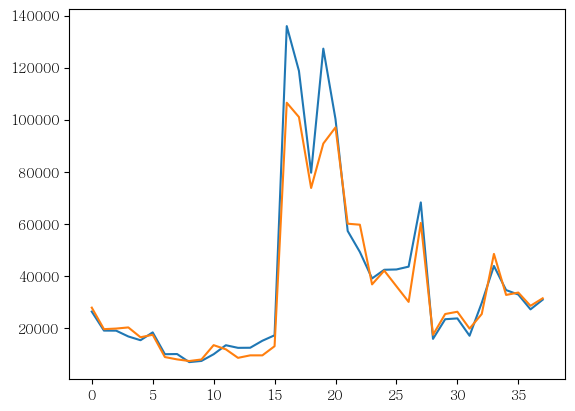

In [110]:
plt.plot(test['real'])
plt.plot(test['predict'])
plt.show()
